<a href="https://colab.research.google.com/github/YujiaoZhao/Carla_Pull/blob/main/AllFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing in libraries
import pandas as pd
import numpy as np
import regex as re
import string
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats as st
import json
import re
from nltk.tokenize.regexp import WhitespaceTokenizer
from nltk import tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher

2022-12-02 05:18:15.369978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Function for Count of Numbers

This function will return a list with the count of numerical values for each String in QText.

In [2]:
def number_count(text):
    """ Input: String
        Output: Number of numerical values in the text
        The function accounts for the fact that there is 
        sometimes commas and decimals in numbers"""
    if type(text) == float:
        return 0
    
    text_wo_punct = text.replace(",", "").replace(".", "")
    number_counts = len(re.findall("[0-9]+", text_wo_punct))
    return number_counts

## Function for Count of Numbers and Number Words

Number words accounts for written out numbers that include hundred, thousand, million, billion, trillion, or dozen.

In [3]:
def number_and_numwords_count(text):
    """ Input: String
        Output: Count of numerical values and 
        number words in each String in the Series.
        The function accounts for the fact that there is 
        sometimes commas and decimals in numbers """
    
    if type(text) == float:
        return 0
    
    text_clean = text.replace(",", "").replace(".", "").lower()
    num_words = len(re.findall(r"\bhundreds?|thousands?|millions?|billions?|trillions?|dozens?\b", text_clean))
    nums = len(re.findall("[0-9]+", text_clean))
    number_counts = num_words + nums
    
    return number_counts

## Has Numerical Value Function
This function will take in a the "QText" column and return an array with 1 for Quotes which contain any type of numerical value (number or number word) and 0 otherwise.

In [4]:
def has_number(text):
    """ Input: String (QText)
        Output: 1 or 0. 1 means that the 
        string contained a number or number word.
        The function accounts for the fact that there is 
        sometimes commas and decimals in numbers """
    if type(text) == float:
        return 0
    
    text_clean = text.replace(",", "").replace(".", "").lower()
    num_words = len(re.findall(r"\bhundreds?\b|\bthousands?\b|\bmillions?\b|\bbillions?\b|\btrillions?\b|\bdozens?\b", text_clean))
    nums = len(re.findall("[0-9]+", text_clean))
    number_counts = num_words + nums
    
    if number_counts > 0:
        return 1
    return 0

## Function for Count of Group Words
When I say "group words," I am referring to the words: us, our, ours, and we.

In [5]:
def group_wrd_count(text):
    """ Input: String (QText)
        Output: Count of group words in 
        each string.
        """
    if type(text) == float:
        return 0
    
    text_lowercase = text.lower()
    text_clean = re.sub(r"[^\w\s]", " ",text_lowercase)
    word_count = len(re.findall(r"\bus\b|\bours?\b|\bwe\b", text_clean)) 
        
    return word_count

## Function for Frequency of Group Words

In [6]:
def group_wrd_freq(text):
    """ Input: String (QText)
        Output: Frequency of group words in 
        text (# of "group words" / total # of words).
        """
    if type(text) == float:
        return 0
    text_lowercase = text.lower()
    text_clean = re.sub(r"[^\w\s]", " ",text_lowercase)
    words_count = len(re.findall(r"\bus\b|\bours?\b|\bwe\b", text_clean)) 
        
    freq = words_count / len(text.split())
        
    return freq

## Function for Has Group Word
This function checks if there is at least one group word in each of a Series of Strings.

In [7]:
def has_group_word(text):
    """ Input: String (QText)
        Output: 1 or 0. 1 means that the 
        string contained a group word.
        """
    text_lowercase = text.lower()
    text_clean = re.sub(r"[^\w\s]", " ",text_lowercase)
    word_count = len(re.findall(r"\bus\b|\bours?\b|\bwe\b", text_clean))
    
    if word_count > 0:
        return 1
    else:
        return 0

## Sentiment Feature Function

In [8]:
vader = SentimentIntensityAnalyzer()

def sentence_vader(string):
    sentence_list = tokenize.sent_tokenize(string)
    score_list = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        score_list.append(score['compound'])
    return np.mean(score_list)

In [9]:
def vader_15(string):
    split_string = string.split(" ")
    length = len(split_string)
    sentence_list = []
    for i in range(length//15):
        sentence = " ".join(split_string[i*15:(i+1)*15])
        sentence_list.append(sentence)
    if length % 15 != 0:
        digit = length%15
        remainder = " ".join(split_string[-digit:])
        sentence_list.append(remainder)
    
    score_list = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        score_list.append(score['compound'])
    return np.mean(score_list)

## Subjectivity Feature Function

In [10]:
#Loading the MPQA Subjectivity Clues Lexicon (https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
mpqa_dict = json.load(open("/Users/carla/Desktop/internships/rethinkmedia/mpqa_dict.json", "r"))

def get_subjectivity(art_str, mpqa_dict):
    subjectivity = 0
    words = re.sub("[^\w]", " ",  art_str).split()
    quote_len = len(words)
    
    for w in words:
        if w in mpqa_dict:  
            if mpqa_dict[w]['subj'] == 'weaksubj':
                subjectivity += 0.1
            if mpqa_dict[w]['subj'] == 'strongsubj':
                subjectivity += 1
    try:
        subjectivity_final = subjectivity*15/quote_len
    except:
        subjectivity_final = 0
    
    return subjectivity_final

## Has Nuke Function

In [11]:
# Indicates if the word 'nuke' was used in the text using regex
def has_nuke(text):
    if type(text) == str:
        return int(len(re.findall("(nukes?[^\w])", text)) > 0)
    else:
        return 0

## Count British Words Function

In [12]:
# Imports british to american word dictionary and function counts number of british words in the text
import requests
url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
british_to_american_dict = requests.get(url).json()
british_words = list(british_to_american_dict.keys())
remove_words = ['buses', 'disc', 'dialogue', 'gramme']
british_words_edited = list(british_to_american_dict.keys())
[british_words_edited.remove(w) for w in remove_words]

def count_british_edited(text):
    count = 0
    if type(text) == str:
        for i in british_words_edited:
            count += text.count(i + " ")
            count += text.count(i + ".")
            count += text.count(i + "?")
            count += text.count(i + ",")
            count += text.count(i + "-")
            count += text.count(i + ":")
    return count

## Final Feature Table

In [13]:
# keeping only news articles and filtering out the unknown sources

GNI88 = pd.read_csv("/Users/carla/Desktop/internships/rethinkmedia/GNI88_cleaned_data.csv")
GNI88 = GNI88[GNI88['Article Status']=='News']
GNI88 = GNI88[GNI88["source_name_cleaned"].str.contains("Unknown|Unnamed|unknown|unnamed", regex=True)==False]

/Users/carla/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9,10,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
# filtering out the organizations sources and the "NO CONTEXT FOUND" quotes

GNI88 = GNI88[GNI88["Source Gender"]!='Organization']
GNI88 = GNI88.drop(labels=[370772, 370773], axis=0).reset_index(drop=True) # This one is an empty quote

In [15]:
GNI88[GNI88["Article ID"]== 52405317]['QText']

Series([], Name: QText, dtype: object)

In [16]:
GNI88.shape

(299981, 30)

In [17]:
sample = GNI88.sample(n=10000)
sample['Number Count'] = sample['QText'].apply(number_count)
sample['Number and Numwords Count'] = sample['QText'].apply(number_and_numwords_count)
sample['Has Number'] = sample['QText'].apply(has_number)
sample['Group Word Count'] = sample['QText'].apply(group_wrd_count)
sample['Group Word Frequency'] = sample['QText'].apply(group_wrd_freq)
sample['Has Group Word'] = sample['QText'].apply(has_group_word)
sample['Sentiment'] = sample['QText'].apply(vader_15)
sample['Subjectivity'] = sample['QText'].apply(get_subjectivity, mpqa_dict=mpqa_dict)
sample['Has Nuke'] = sample['QText'].apply(has_nuke)
sample['British Word Count'] = sample['QText'].apply(count_british_edited)

In [18]:
new_feature = ['Number Count', 'Number and Numwords Count', 'Has Number', 'Group Word Count', 
                    'Group Word Frequency', 'Has Group Word', 'Sentiment', 'Subjectivity', 'Has Nuke',
                    'British Word Count']

In [19]:
from ModelReview import *

/var/folders/tc/bh92rdln5b97ks_khyc1_kbh0000gn/T/ipykernel_44359/3713888292.py:1: DtypeWarning: Columns (9,10,24) have mixed types.Specify dtype option on import or set low_memory=False.
  from ModelReview import *


In [20]:
# creating a column for feature information
sample["speaker_context"] = sample.apply(lambda row: fancy_context(row["Article ID"], row['source_name_cleaned'], verbose=False),axis=1)

In [21]:
# creating a column for label information
sample["speaker_group"] = sample.apply(lambda row: assign_source_to_group(row["Source Type"]), axis=1)

In [22]:
# creating a special indicator column to hopefully discern foreign government sources
sample["has_foreign_title"] = sample.apply(lambda row: has_foreign_title(row.speaker_context), axis = 1)

In [23]:
sample.head(5)

,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Group Word Count,Group Word Frequency,Has Group Word,Sentiment,Subjectivity,Has Nuke,British Word Count,speaker_context,speaker_group,has_foreign_title
142381,2011-04-06,5184137,"ON GUARD IN CITY NYPD stages drill to find ""di...",8982918,News,Neutral,OLD Proliferation,OLD Terrorist Threat,Neutral,NaN,...,0,0.000000,0,0.00000,0.136364,0,0,"out from the city,"" said inspector stuart cam...",Other,0
255967,2020-05-21,9393802,Pompeo Announces Open Skies Withdrawal,12555481,News,Neutral,Arms Reduction,START,Positive,NaN,...,0,0.000000,0,-0.72690,2.500000,0,0,",” trump’s special envoy for arms control,",US Federal Officials,0
164732,2013-03-26,5188232,Report: Sanctions may be speeding Iran's nucle...,9075303,News,Neutral,OLD Iran,OLD Sanctions,Neutral,NaN,...,1,0.045455,1,-0.17875,0.954545,0,0,author,Experts,0
217671,2014-01-12,5210185,Iran says nuclear deal takes effect on Jan. 20...,9054198,News,Neutral,OLD Iran,OLD Negotiations,Neutral,NaN,...,0,0.000000,0,0.00000,0.868421,0,0,... the geneva deal will be implemented from j...,Foreign Government,0
42416,2017-05-14,5148397,Lawmakers move to step up defenses against Nor...,8887225,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,0,0.000000,0,0.00000,1.086207,0,0,strategic command head gen.,US Defense,0


In [24]:
sample = sample[sample['speaker_context'] != '# NO CONTEXT FOUND #']

In [25]:
sample.shape

(9273, 43)

In [26]:
X = []
X_verbose = []
for context_str in sample["speaker_context"]:
    X_verbose.append(context_str)
    X.append(extract_speaker_indicators_binary(context_str, speaker_dict))
    #X.append(extract_counts(context_str,indicator_pattern_set))
X = np.array(X)
foreign_title_indicators = np.array([np.array([ind]) for ind in sample["has_foreign_title"]])
X = np.hstack((X,foreign_title_indicators))
new_feature_table = np.array(sample[new_feature])
X = np.hstack((X,new_feature_table))

# Y is the broader group of speakers to which the source of the quote belongs
y = np.array(sample["speaker_group"])

In [27]:
X.shape

(9273, 21)

### There are 21 features in total. The first 10 are speaker indicators, the 11th is foreign title indicator, and the rest are our new features.

In [28]:
# train-test split for trial logistic classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

## Try: Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# fitting the trial logistic classifier
log_clf = LogisticRegression(max_iter=3000).fit(X_train, y_train)
# score for trial logistic classifier
log_clf.score(X_test,y_test)

0.6175413371675054

In [30]:
y_pred = log_clf.predict(X_test)
classification_report(y_test, y_pred)

'                      precision    recall  f1-score   support\n\n  Corporate Official       0.43      0.20      0.28        44\n             Experts       0.67      0.51      0.58       563\n  Foreign Government       0.55      0.74      0.63       753\n               Media       0.56      0.62      0.59       226\n               Other       0.00      0.00      0.00        62\n         US Congress       0.71      0.53      0.61       323\n          US Defense       0.28      0.45      0.34        69\nUS Federal Officials       0.73      0.71      0.72       742\n\n            accuracy                           0.62      2782\n           macro avg       0.49      0.47      0.47      2782\n        weighted avg       0.62      0.62      0.61      2782\n'

## Try: Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

# fitting the trial random forest classifier
randforest_clf = RandomForestClassifier(max_depth=90, random_state=0, n_estimators=300).fit(X_train, y_train)
# score for trial random forest classifier
randforest_clf.score(X_test,y_test)

0.595255212077642

In [32]:
y_pred = randforest_clf.predict(X_test)
classification_report(y_test, y_pred)

'                      precision    recall  f1-score   support\n\n  Corporate Official       0.33      0.20      0.25        44\n             Experts       0.53      0.53      0.53       563\n  Foreign Government       0.64      0.66      0.65       753\n               Media       0.50      0.53      0.51       226\n               Other       0.00      0.00      0.00        62\n         US Congress       0.59      0.58      0.58       323\n          US Defense       0.26      0.28      0.27        69\nUS Federal Officials       0.68      0.71      0.69       742\n\n            accuracy                           0.60      2782\n           macro avg       0.44      0.44      0.44      2782\n        weighted avg       0.58      0.60      0.59      2782\n'

In [33]:
# feature importance

importances = randforest_clf.feature_importances_

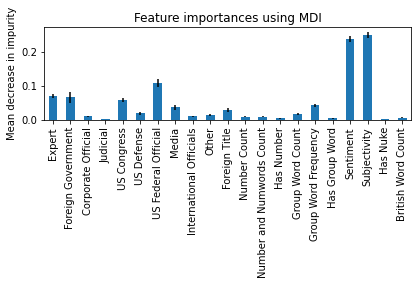

In [34]:
feature_names = ['Expert', 'Foreign Government', 'Corporate Official', 'Judicial', 'US Congress', 'US Defense',
                'US Federal Official', 'Media', 'International Officials', 'Other', 'Foreign Title', 'Number Count', 
                'Number and Numwords Count', 'Has Number', 'Group Word Count', 'Group Word Frequency', 
                'Has Group Word', 'Sentiment', 'Subjectivity', 'Has Nuke', 'British Word Count']


forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in randforest_clf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Try: Support Vector Machine

In [35]:
from sklearn import svm
from sklearn import metrics

# fitting the trial SVM classifier
svm_clf = svm.SVC(kernel='linear').fit(X_train, y_train)
# score for trial SVM classifier
y_pred = svm_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6236520488856937


In [36]:
y_pred = svm_clf.predict(X_test)
classification_report(y_test, y_pred)

/Users/carla/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carla/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carla/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                      precision    recall  f1-score   support\n\n  Corporate Official       0.40      0.27      0.32        44\n             Experts       0.67      0.55      0.60       563\n  Foreign Government       0.55      0.76      0.64       753\n               Media       0.56      0.61      0.58       226\n               Other       0.00      0.00      0.00        62\n         US Congress       0.68      0.56      0.62       323\n          US Defense       0.26      0.45      0.33        69\nUS Federal Officials       0.79      0.66      0.72       742\n\n            accuracy                           0.62      2782\n           macro avg       0.49      0.48      0.48      2782\n        weighted avg       0.63      0.62      0.62      2782\n'

## Hyperparameter Tuning

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear']}

def findBestSVMParameters(param_grid, X_train, y_train):
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
    grid.fit(X_train, y_train)
    grid_predictions = grid.predict(X_test)
    return grid.best_params_, grid_predictions

findBestSVMParameters(param_grid, X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.575 total time=   2.6s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.573 total time=   2.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.586 total time=   2.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.590 total time=   2.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.599 total time=   2.5s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.614 total time=   1.2s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.619 total time=   1.2s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.617 total time=   1.2s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.616 total time=   1.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.616 total time=   1.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.594 total time=   2.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.620 total time=   2.1s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.624 total time=   2.1s
[CV 4/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.621 total time=   2.1s
[CV 5/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.622 total time=   2.2s
[CV 1/5] END ...C=10, gamma=0.01, kernel=linear;, score=0.625 total time=   3.2s
[CV 2/5] END ...C=10, gamma=0.01, kernel=linear;, score=0.616 total time=   3.9s
[CV 3/5] END ...C=10, gamma=0.01, kernel=linear;, score=0.626 total time=   3.0s
[CV 4/5] END ...C=10, gamma=0.01, kernel=linear;, score=0.624 total time=   3.4s
[CV 5/5] END ...C=10, gamma=0.01, kernel=linear;, score=0.631 total time=   3.5s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.591 total time=   2.1s
[CV 2/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.606 total time=   2.1s
[CV 3/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.602 total time=   2.1s
[CV 4/5] END .....C=10, gamm

({'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
 array(['Foreign Government', 'Experts', 'Media', ...,
        'Foreign Government', 'Foreign Government', 'Media'], dtype=object))

In [39]:
# fitting the trial SVM classifier
svm_clf = svm.SVC(kernel='rbf', C=10, gamma=0.1).fit(X_train, y_train)
# score for trial SVM classifier
y_pred = svm_clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.6268871315600287


In [40]:
y_pred = svm_clf.predict(X_test)
classification_report(y_test, y_pred)


'                      precision    recall  f1-score   support\n\n  Corporate Official       0.50      0.34      0.41        44\n             Experts       0.65      0.54      0.59       563\n  Foreign Government       0.56      0.75      0.64       753\n               Media       0.56      0.60      0.58       226\n               Other       0.00      0.00      0.00        62\n         US Congress       0.72      0.54      0.61       323\n          US Defense       0.27      0.45      0.34        69\nUS Federal Officials       0.77      0.70      0.73       742\n\n            accuracy                           0.63      2782\n           macro avg       0.50      0.49      0.49      2782\n        weighted avg       0.63      0.63      0.62      2782\n'